In [ ]:
#|hide
#|default_exp experiments.curvature_curves
## Standard libraries
import os
import math
import numpy as np
import time
from fastcore.all import *
from nbdev.showdoc import *
from functools import partial

# Configure environment
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false' # Tells Jax not to hog all of the memory to this process.

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgba
import seaborn as sns
sns.set()

## Progress bar
from tqdm.auto import tqdm, trange

## project specifics
import diffusion_curvature
import pygsp
import jax
import jax.numpy as jnp
jax.devices()

from diffusion_curvature.graphs import *
from diffusion_curvature.datasets import *
from diffusion_curvature.core import *
from diffusion_curvature.utils import *
from diffusion_curvature.comparison_space import *

# Utility functions for literate programming
def get_var_name(instance):
    return [name for name, obj in globals().items() if obj is instance][0]

%load_ext autoreload
%autoreload 2

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


# 3a Are Kernels Zeitgeibers?
> Perhaps comparison curvature is hampered by *time*, which goes faster or slower depending on kernel bandwidth?

The idea is that the disparities in our spatial comparisons are not due to the kernel disrupting the graph, but rather because the kernel assigns each graph a distinct timescale during diffusion. This is based on the idea that graph kernels act as "zeitgebers" of diffusion, with different curvatures leading to varying kernel parameters even when adaptive bandwidths are used. The issue is most pronounced in high-dimensional spaces, where sparse data makes the kernel more sensitive to curvature-induced variations between manifolds.


*Hypothesis*: The difference in 'curvature curves' between identically sampled manifolds operated on by different kernels can be equalized by changing the speed of diffusion time.

# Machinery

First we need an apparatus for conventiently computing 'curvature curves', that is the variations of laziness as a function of the power $t$. We'll piggyback on the existing `DiffusionCurvature` class with a mixins `@patch` that defines a 'curvature curve' function. This patch will create a linspace of `t`s, then call `self.unsigned_curvature(self.G, t)` over that linspace, returning the resutls. 

We'll then define a helper function, 'curvature_curves', that accepts as input any number of `DiffusionCurvature` classes with precomputed $P$s, and plots them the results of our patch.

In [ ]:
#|export
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
from fastcore.all import *
from diffusion_curvature.core import *
from tqdm.auto import tqdm
import inspect

@patch
def curvature_curve(self:DiffusionCurvature, 
                    num_ts=50, 
                    idx = 0, 
                    curvature_fn:str = 'unsigned_curvature', # name of local DiffusionCurvature method to call. Should take as input G and t and kwargs
                    **kwargs
                    ):
    method = getattr(self, curvature_fn, lambda: "Function not found")
    
    t_values = np.arange(1, num_ts+1)
    curvatures = np.array([method(self.G, int(t), **kwargs)[idx] for t in tqdm(t_values)])
    return t_values, curvatures

def show_curvature_curves(*diffusion_curvatures, num_ts = 50, idx = 0, scaling_fn = None, title = "Curvature Curves", curvature_fn = "unsigned_curvature", **kwargs):
    # fig, ax = plt.subplots(1)
    for dc in diffusion_curvatures:
        for frame_record in inspect.stack():
            frame = frame_record.frame
            for name, obj in frame.f_globals.items():
                if obj is dc:
                    dc_name = name
            for name, obj in frame.f_locals.items():
                if obj is dc:
                    dc_name = name
        t_values, curvatures = dc.curvature_curve(num_ts = num_ts, idx=idx, curvature_fn=curvature_fn, **kwargs)
        plt.plot(t_values, curvatures, label=dc_name)
    plt.xlabel('Time ($t$)')
    plt.ylabel('Curvature')
    plt.title(title)
    plt.legend()
    plt.show()

We additionally have a `scaling_fn` which, given a pair of curvature curves, scales them.
Here we define a couple of scaling functions:

1. *Bottom-up scaling*. Intuitively, the curvature curves should have the same behavior at small scales, where the graph is still (per the Manifold Hypothesis) locally Euclidean. This method aligns them to start at the same value, and then compresses time (equivalent to scaling the kernel bandwidth) such that the early values agree.

In [ ]:
def bottom_up_scaling(curve1, curve2):
    # find curve with greater starting spread
    curves = [curve1, curve2]
    greater_idx = np.argmax([c[0] for c in curves])
    smaller_idx = 1-greater_idx
    # Discard values in the smaller idx below the starting point of greater idx
    only_greater_than_greater_than = [d >= curves[greater_idx][0] for d in curves[smaller_idx]]
    new_small_curve = curves[smaller_idx][only_greater_than_greater_than]
    new_curves = [new_small_curve, curves[greater_idx]]
    # Now that both kernels have an equal starting point, we scale time such that they have roughly equal first step
    # first_steps = [
    



# Results

## Proof of Concept with the 2d Saddle, Plane, and Sphere

In [ ]:
X_saddle, ks = rejection_sample_from_saddle(2000, intrinsic_dim=2)
graph_former = partial(get_adaptive_graph, alpha=1, k=5)
G_saddle = graph_former(X_saddle)
DC_saddle = DiffusionCurvature(
    laziness_method="Wasserstein",
    flattening_method="Fixed",
    comparison_method="Ollivier",
    graph_former=graph_former,
    points_per_cluster=None,  # construct separate comparison spaces around each point
    comparison_space_size_factor=1,
    verbose=False,
    distance_t = 25 # prevents the distances from changing along with the t value for easier comparison
)
ks = DC_saddle.fit_transform(G_saddle, dim=2, t=25)

2024-03-28 11:36:14,518:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-03-28 11:36:15,088:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!


In [ ]:
X_sphere, ks_sphere = sphere(2000, d=2)
graph_former = partial(get_adaptive_graph, alpha=1, k=5)
G_sphere = graph_former(X_sphere)
DC_sphere = DiffusionCurvature(
    laziness_method="Wasserstein",
    flattening_method="Fixed",
    comparison_method="Ollivier",
    graph_former=graph_former,
    points_per_cluster=None,  # construct separate comparison spaces around each point
    comparison_space_size_factor=1,
    verbose=False,
    distance_t = 25 # prevents the distances from changing along with the t value for easier comparison
)
ks = DC_sphere.fit_transform(G_sphere, dim=2, t=25)

2024-03-28 11:36:15,652:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-03-28 11:36:16,268:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!


In [ ]:
X_plane = plane(2000, dim=2)
graph_former = partial(get_adaptive_graph, alpha=1, k=5)
G_plane = graph_former(X_plane)
DC_plane = DiffusionCurvature(
    laziness_method="Wasserstein",
    flattening_method="Fixed",
    comparison_method="Ollivier",
    graph_former=graph_former,
    points_per_cluster=None,  # construct separate comparison spaces around each point
    comparison_space_size_factor=1,
    verbose=False,
    distance_t = 25 # prevents the distances from changing along with the t value for easier comparison
)
ks = DC_plane.fit_transform(G_plane, dim=2, t=25)

2024-03-28 11:36:18,935:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-03-28 11:36:19,443:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

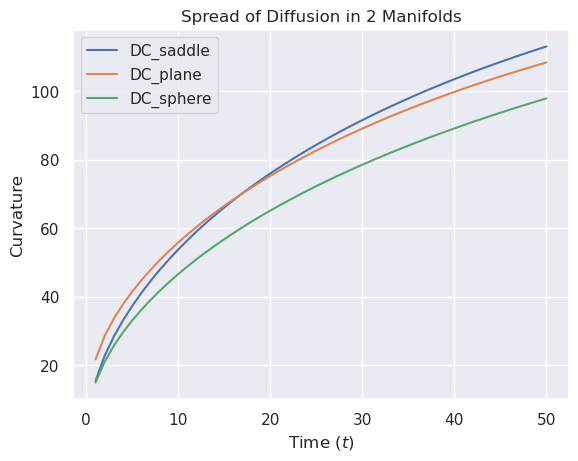

In [ ]:
#| label: fig-spread-of-diffusion-2d
#| fig-cap: Spread of Diffusion in 2 Manifolds
#| fig-alt: Three lines,e sloping upwards with varying sharpness, represent the 'spread' of diffusion on three manifolds. The saddle is sharpest, the sphere the least so.
show_curvature_curves(DC_saddle, DC_plane, DC_sphere, num_ts=50, title = "Spread of Diffusion in 2 Manifolds")

## How about the above in 3d?

In [ ]:
X_saddle, ks = rejection_sample_from_saddle(2000, intrinsic_dim=3)
graph_former = partial(get_adaptive_graph, alpha=1, k=5)
G_saddle = graph_former(X_saddle)
DC_saddle = DiffusionCurvature(
    laziness_method="Wasserstein",
    flattening_method="Fixed",
    comparison_method="Ollivier",
    graph_former=graph_former,
    points_per_cluster=None,  # construct separate comparison spaces around each point
    comparison_space_size_factor=1,
    verbose=False,
    distance_t = 25 # prevents the distances from changing along with the t value for easier comparison
)
ks = DC_saddle.fit_transform(G_saddle, dim=2, t=25)

2024-03-28 11:14:15,567:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-03-28 11:14:16,127:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!


In [ ]:
X_sphere, ks_sphere = sphere(2000, d=3)
graph_former = partial(get_adaptive_graph, alpha=1, k=5)
G_sphere = graph_former(X_sphere)
DC_sphere = DiffusionCurvature(
    laziness_method="Wasserstein",
    flattening_method="Fixed",
    comparison_method="Ollivier",
    graph_former=graph_former,
    points_per_cluster=None,  # construct separate comparison spaces around each point
    comparison_space_size_factor=1,
    verbose=False,
    distance_t = 25 # prevents the distances from changing along with the t value for easier comparison
)
ks = DC_sphere.fit_transform(G_sphere, dim=2, t=25)

2024-03-28 11:14:16,696:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-03-28 11:14:17,273:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!


In [ ]:
X_plane = plane(2000, dim=3)
graph_former = partial(get_adaptive_graph, alpha=1, k=5)
G_plane = graph_former(X_plane)
DC_plane = DiffusionCurvature(
    laziness_method="Wasserstein",
    flattening_method="Fixed",
    comparison_method="Ollivier",
    graph_former=graph_former,
    points_per_cluster=None,  # construct separate comparison spaces around each point
    comparison_space_size_factor=1,
    verbose=False,
    distance_t = 25 # prevents the distances from changing along with the t value for easier comparison
)
ks = DC_plane.fit_transform(G_plane, dim=2, t=25)

2024-03-28 11:14:17,871:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-03-28 11:14:18,459:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!


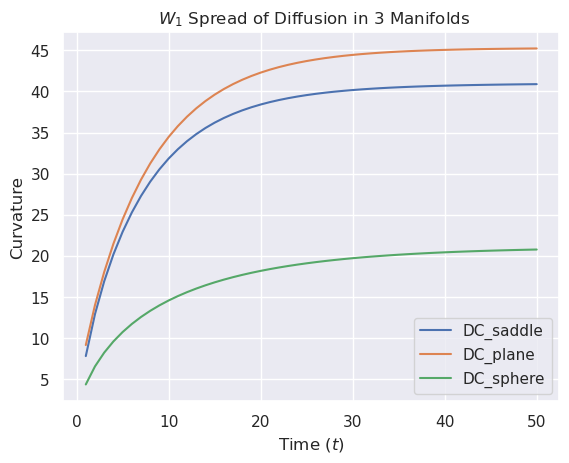

In [ ]:
show_curvature_curves(DC_saddle, DC_plane, DC_sphere, num_ts=50, title = " $W_1$ Spread of Diffusion in 3 Manifolds")

## Performance with Kernel Matching Comparisons

In [ ]:
X_saddle, ks = rejection_sample_from_saddle(2000, intrinsic_dim=3)
graph_former = partial(get_adaptive_graph, alpha=1, k=5)
G_saddle = graph_former(X_saddle)
DC_saddle = DiffusionCurvature(
    laziness_method="Wasserstein",
    flattening_method="Kernel Matching",
    comparison_method="Ollivier",
    graph_former=graph_former,
    points_per_cluster=None,  # construct separate comparison spaces around each point
    comparison_space_size_factor=1,
    verbose=True,
    distance_t = 25 # prevents the distances from changing along with the t value for easier comparison
)
ks = DC_saddle.fit_transform(G_saddle, dim=2, t=25)

2024-03-28 11:15:02,145:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!


Manifold spreads are [38.70983  35.193085 36.498962 ... 37.46466  37.57095  38.982735]
average_dim_in_cluster=2
{'params': {'kernel bandwidth': Array([nan], dtype=float32)}}


ValueError: Input contains NaN.

In [ ]:
X_sphere, ks_sphere = sphere(2000, d=3)
graph_former = partial(get_adaptive_graph, alpha=1, k=5)
G_sphere = graph_former(X_sphere)
DC_sphere = DiffusionCurvature(
    laziness_method="Wasserstein",
    flattening_method="Fixed",
    comparison_method="Ollivier",
    graph_former=graph_former,
    points_per_cluster=None,  # construct separate comparison spaces around each point
    comparison_space_size_factor=1,
    verbose=False,
    distance_t = 25 # prevents the distances from changing along with the t value for easier comparison
)
ks = DC_sphere.fit_transform(G_sphere, dim=2, t=25)

In [ ]:
X_plane = plane(2000, dim=3)
graph_former = partial(get_adaptive_graph, alpha=1, k=5)
G_plane = graph_former(X_plane)
DC_plane = DiffusionCurvature(
    laziness_method="Wasserstein",
    flattening_method="Fixed",
    comparison_method="Ollivier",
    graph_former=graph_former,
    points_per_cluster=None,  # construct separate comparison spaces around each point
    comparison_space_size_factor=1,
    verbose=False,
    distance_t = 25 # prevents the distances from changing along with the t value for easier comparison
)
ks = DC_plane.fit_transform(G_plane, dim=2, t=25)

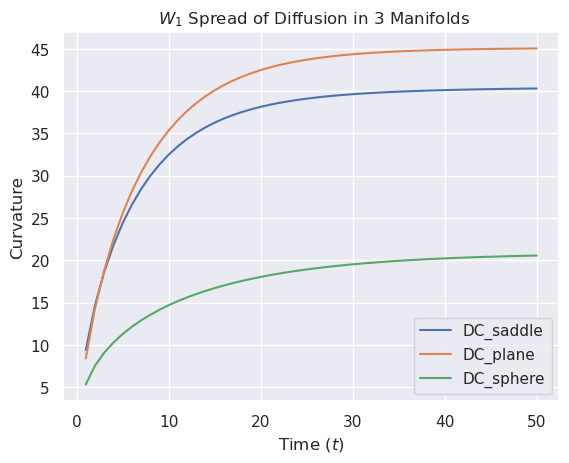

In [ ]:
show_curvature_curves(DC_saddle, DC_plane, DC_sphere, num_ts=50, title = " $W_1$ Spread of Diffusion in 3 Manifolds")

## With the Heat Kernel

In [ ]:
from diffusion_curvature.heat_diffusion import *

In [ ]:
Ps = heat_diffusion_from_dirac(G_saddle, idx=0, t=[1,4, 15])

In [ ]:
Ps[2]

Array([7.3713613e-01, 9.0329522e-09, 6.6748148e-06, ..., 3.1011127e-06,
       8.0615180e-03, 8.9100868e-06], dtype=float32)

In [ ]:
X_saddle, ks = rejection_sample_from_saddle(2000, intrinsic_dim=3)
graph_former = partial(get_adaptive_graph, alpha=1, k=5)
G_saddle = graph_former(X_saddle)
DC_saddle = DiffusionCurvature(
    laziness_method="Wasserstein",
    flattening_method="Fixed",
    comparison_method="Subtraction",
    diffusion_type='heat kernel',
    graph_former=graph_former,
    points_per_cluster=None,  # construct separate comparison spaces around each point
    comparison_space_size_factor=1,
    verbose=False,
    distance_t = 25 # prevents the distances from changing along with the t value for easier comparison
)
ks = DC_saddle.fit_transform(G_saddle, dim=2, t=25)

2024-03-07 17:42:56,918:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2024-03-07 17:43:00,286:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!


ValueError: Expected 2D array, got 1D array instead:
array=[ 0.30286053 13.815511   13.815511   ... 13.815511    4.6863
 13.815308  ].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
DC_saddle.idx

AttributeError: 'DiffusionCurvature' object has no attribute 'idx'

In [ ]:
X_sphere, ks_sphere = sphere(2000, d=3)
graph_former = partial(get_adaptive_graph, alpha=1, k=5)
G_sphere = graph_former(X_sphere)
DC_sphere = DiffusionCurvature(
    laziness_method="Wasserstein",
    flattening_method="Fixed",
    comparison_method="Ollivier",
    graph_former=graph_former,
    points_per_cluster=None,  # construct separate comparison spaces around each point
    comparison_space_size_factor=1,
    verbose=False,
    distance_t = 25 # prevents the distances from changing along with the t value for easier comparison
)
ks = DC_sphere.fit_transform(G_sphere, dim=2, t=25)

In [ ]:
X_plane = plane(2000, dim=3)
graph_former = partial(get_adaptive_graph, alpha=1, k=5)
G_plane = graph_former(X_plane)
DC_plane = DiffusionCurvature(
    laziness_method="Wasserstein",
    flattening_method="Fixed",
    comparison_method="Ollivier",
    graph_former=graph_former,
    points_per_cluster=None,  # construct separate comparison spaces around each point
    comparison_space_size_factor=1,
    verbose=False,
    distance_t = 25 # prevents the distances from changing along with the t value for easier comparison
)
ks = DC_plane.fit_transform(G_plane, dim=2, t=25)

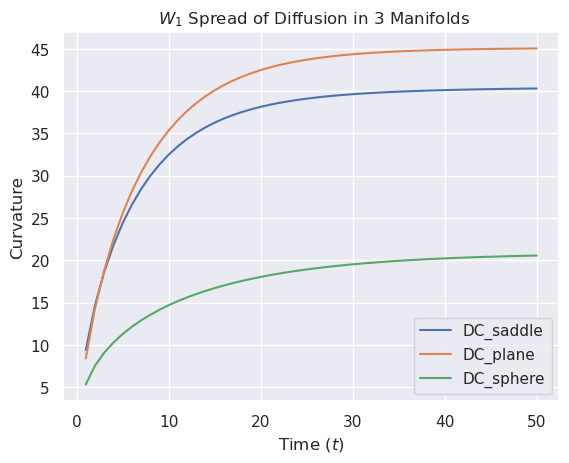

In [ ]:
show_curvature_curves(DC_saddle, DC_plane, DC_sphere, num_ts=50, title = " $W_1$ Spread of Diffusion in 3 Manifolds")

# Conclusion